### 生成数据集

给定$x$，我们将[**使用以下三阶多项式来生成训练和测试数据的标签：**]

(**$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$**)

噪声项$\epsilon$服从均值为0且标准差为0.1的正态分布。
在优化的过程中，我们通常希望避免非常大的梯度值或损失值。
这就是我们将特征从$x^i$调整为$\frac{x^i}{i!}$的原因，
这样可以避免很大的$i$带来的特别大的指数值。
我们将为训练集和测试集各生成100个样本。


In [1]:
import math
import numpy as np
import torch
from torch import nn
from torch.utils import data
from IPython import display
import matplotlib.pyplot as plt
torch.cuda.set_device(1)

# 生成数据集

In [2]:
max_degree = 20
n_train, n_test = 1000, 1000
true_w = np.zeros(max_degree)
true_w[0:6] = np.array([5,1.2,-3.4,5.6,5.8,-3.7])

features = np.random.normal(size=(n_train+n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
  poly_features[:,i] /= math.gamma(i+1) # gamma(n) = (n-1)!
# labels的维度(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)
# print(labels)

In [3]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

In [4]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.3119],
         [ 0.9775]]),
 tensor([[ 1.0000e+00, -1.3119e+00,  8.6057e-01, -3.7633e-01,  1.2343e-01,
          -3.2386e-02,  7.0813e-03, -1.3271e-03,  2.1764e-04, -3.1725e-05,
           4.1621e-06, -4.9639e-07,  5.4269e-08, -5.4766e-09,  5.1321e-10,
          -4.4886e-11,  3.6804e-12, -2.8402e-13,  2.0701e-14, -1.4294e-15],
         [ 1.0000e+00,  9.7755e-01,  4.7780e-01,  1.5569e-01,  3.8049e-02,
           7.4390e-03,  1.2120e-03,  1.6926e-04,  2.0682e-05,  2.2464e-06,
           2.1960e-07,  1.9515e-08,  1.5898e-09,  1.1954e-10,  8.3471e-12,
           5.4398e-13,  3.3236e-14,  1.9111e-15,  1.0379e-16,  5.3401e-18]]),
 tensor([-0.8464,  5.5719]))

In [5]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

# 训练

In [6]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self,*args):
        self.data = [a + float(b) for a,b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) #正确预测数，预测总数
    with torch.no_grad():
        for X,y in data_iter:
            metric.add(accuracy(net(X),y),y.numel())
    return metric[0] / metric[1]

In [7]:
def evaluate_loss(net, data_iter, loss):
  """评估给定数据集上模型的损失"""
  metric = Accumulator(2) # 损失的总和、样本数量
  for X, y in data_iter:
    out = net(X)
    y = y.reshape(out.shape)
    l = loss(out, y)
    metric.add(l.sum(), l.numel())
  return metric[0] / metric[1]

In [8]:
class Animator:
  """在动画中绘制数据"""
  def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
               ylim=None, xscale='linear',yscale='linear',
               fmts=('-','m--','g-','r:'),nrows=1,ncols=1,
               figsize=(3.5,2.5)):
    if legend is None:
      legend = []
    # d2l.use_svg_display()
    self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
    if nrows * ncols == 1:
      self.axes = [self.axes, ]
    self.X, self.Y, self.fmts = None, None, fmts
  
  def add(self, x,y):
    #向图表添加多个数据点
    if not hasattr(y,"__len__"):
      y = [y]
    n = len(y)
    if not hasattr(x,"__len__"):
      x = [x] * n
    if not self.X:
      self.X = [[] for _ in range(n)]
    if not self.Y:
      self.Y = [[] for _ in range(n)]
    for i, (a,b) in enumerate(zip(x,y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
    self.axes[0].cla()
    for x,y,fmt in zip(self.X,self.Y,self.fmts):
      self.axes[0].plot(x,y,fmt)
    display.display(self.fig)
    display.clear_output(wait=True)

In [9]:
def train_epoch(net, train_iter, loss ,updater):
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式(计算梯度)
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X,y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1]/metric[2]

In [10]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
  loss = nn.MSELoss(reduction='none')
  input_shape = train_features.shape[-1]
  net = nn.Sequential(nn.Linear(input_shape,1,bias=False))
  batch_size = min(10,train_labels.shape[0])
  train_iter = load_array((train_features, train_labels.reshape(-1,1)), batch_size)
  test_iter = load_array((test_features, test_labels.reshape(-1,1)), batch_size, is_train=False)
  trainer = torch.optim.SGD(net.parameters(), lr=0.01)
  animator = Animator(xlabel='epoch',ylabel='loss',yscale='log',xlim=[1,num_epochs],ylim=[1e-3,1e2],legend=['train','test'])
  for epoch in range(num_epochs):
    train_epoch(net, train_iter, loss, trainer)
    if epoch == 0 or (epoch+1)  % 20 == 0:
      animator.add(epoch+1,(evaluate_loss(net,train_iter,loss),evaluate_loss(net,test_iter,loss)))
  print("weight:", net[0].weight.data.numpy())

In [11]:
# 正常情况
# train(poly_features[:n_train,:4], poly_features[n_train:, :4],
#       labels[:n_train], labels[n_train:])

In [12]:
# 欠拟合
# train(poly_features[:n_train,:2], poly_features[n_train:, :2],
#       labels[:n_train], labels[n_train:])

weight: [[ 4.992603    1.1992589  -3.3785744   5.570983    5.7029943  -3.4132228
   0.37310886 -1.2262203  -0.17919126 -0.03500626  0.15904509  0.02056182
   0.19512069 -0.05585922  0.1224516  -0.02757542  0.20561147  0.11027409
   0.10102785 -0.04503408]]


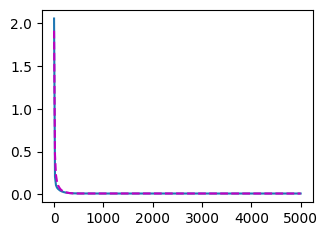

In [13]:
# 过拟合
train(poly_features[:n_train,:], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:],num_epochs=5000)